## 1. Import Relevant Libraries


In [88]:
# import libraries
import pandas as pd
import numpy as np
import nltk
from pprint import pprint
nltk.download(['punkt', 'wordnet', 'stopwords'])
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 
import spacy
import scattertext as st
import pickle
import seaborn as sn
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /Users/sabrina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sabrina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sabrina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !python -m spacy download en_core_web_lg

## 2. Data Understanding

In [35]:
# load data from database
engine = create_engine('sqlite:///disaster_response.db')
df = pd.read_sql_table('disaster_response', engine)
Y = df.iloc[:, 4:] # Classification label
categories = df.columns[4:]
df.shape

(26216, 39)

In [63]:
df

id                                            message  \
0          2    weather update cold front cuba could pass haiti   
1          7                                          hurricane   
2          8                               looking someone name   
3          9  un reports leogane 8090 destroyed hospital st ...   
4         12    says west side haiti rest country today tonight   
...      ...                                                ...   
26211  30261  training demonstrated enhance micronutrient pr...   
26212  30262  suitable candidate selected ocha jakarta curre...   
26213  30263  proshika operating coxs bazar municipality 5 u...   
26214  30264  2000 women protesting conduct elections tearga...   
26215  30265  radical shift thinking came result meeting rec...   

                                                original   genre  related  \
0      Un front froid se retrouve sur Cuba ce matin. ...  direct        1   
1                     Cyclone nan fini osinon li pa fini  direct        1   
2      Patnm, di Maryani relem pou li banm nouvel li ...  direct        1   
3      UN reports Leogane 80-90 destroyed. Only Hospi...  direct        1   
4      facade ouest d Haiti et le reste du pays aujou...  direct        1   
...                                                  ...     ...      ...   
26211                                               None    news        0   
26212                                               None    news        0   
26213                                               None    news        1   
26214                                               None    news        1   
26215                                               None    news        1   

       request  offer  aid_related  medical_help  medical_products  ...  \
0            0      0            0             0                 0  ...   
1            0      0            1             0                 0  ...   
2            0      0            0             0                 0  ...   
3            1      0            1             0                 1  ...   
4            0      0            0             0                 0  ...   
...        ...    ...          ...           ...               ...  ...   
26211        0      0            0             0                 0  ...   
26212        0      0            0             0                 0  ...   
26213        0      0            0             0                 0  ...   
26214        0      0            1             0                 0  ...   
26215        0      0            0             0                 0  ...   

       weather_related  floods  storm  fire  earthquake  cold  other_weather  \
0                    0       0      0     0           0     0              0   
1                    1       0      1     0           0     0              0   
2                    0       0      0     0           0     0              0   
3                    0       0      0     0           0     0              0   
4                    0       0      0     0           0     0              0   
...                ...     ...    ...   ...         ...   ...            ...   
26211                0       0      0     0           0     0              0   
26212                0       0      0     0           0     0              0   
26213                0       0      0     0           0     0              0   
26214                0       0      0     0           0     0              0   
26215                0       0      0     0           0     0              0   

       direct_report  help_needed  match  
0                  0          Yes   True  
1                  0          Yes   True  
2                  0          Yes   True  
3                  0          Yes   True  
4                  0          Yes   True  
...              ...          ...    ...  
26211              0           No   True  
26212              0           No   True  
26213              0          Y

In [36]:
X

0        Weather update - a cold front from Cuba that c...
1                  Is the Hurricane over or is it not over
2                          Looking for someone but no name
3        UN reports Leogane 80-90 destroyed. Only Hospi...
4        says: west side of Haiti, rest of the country ...
                               ...                        
26211    The training demonstrated how to enhance micro...
26212    A suitable candidate has been selected and OCH...
26213    Proshika, operating in Cox's Bazar municipalit...
26214    Some 2,000 women protesting against the conduc...
26215    A radical shift in thinking came about as a re...
Name: message, Length: 26216, dtype: object

In [89]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [90]:
df['message'] = df['message'].str.replace("[^\w\s]", "").str.lower()
df['message'] = df['message'].apply(lambda x: ' '.join([item for item in x.split() if item not in stopWords]))
df['message'] = df['message'].apply(stemming)
X = df['message']  # Message Column

df['genre'].value_counts()

news      13054
direct    10766
social     2396
Name: genre, dtype: int64

In [91]:
df

id                                            message  \
0          2     weather updat cold front cuba could pass haiti   
1          7                                           hurrican   
2          8                                   look someon name   
3          9  un report leogan 8090 destroy hospit st croix ...   
4         12     say west side haiti rest countri today tonight   
...      ...                                                ...   
26211  30261  train demonstr enhanc micronutri protein energ...   
26212  30262  suitabl candid select ocha jakarta current wor...   
26213  30263  proshika oper cox bazar municip 5 union ramu c...   
26214  30264  2000 women protest conduct elect teargass tri ...   
26215  30265  radic shift think came result meet recogn hiva...   

                                                original   genre  related  \
0      Un front froid se retrouve sur Cuba ce matin. ...  direct        1   
1                     Cyclone nan fini osinon li pa fini  direct        1   
2      Patnm, di Maryani relem pou li banm nouvel li ...  direct        1   
3      UN reports Leogane 80-90 destroyed. Only Hospi...  direct        1   
4      facade ouest d Haiti et le reste du pays aujou...  direct        1   
...                                                  ...     ...      ...   
26211                                               None    news        0   
26212                                               None    news        0   
26213                                               None    news        1   
26214                                               None    news        1   
26215                                               None    news        1   

       request  offer  aid_related  medical_help  medical_products  ...  \
0            0      0            0             0                 0  ...   
1            0      0            1             0                 0  ...   
2            0      0            0             0                 0  ...   
3            1      0            1             0                 1  ...   
4            0      0            0             0                 0  ...   
...        ...    ...          ...           ...               ...  ...   
26211        0      0            0             0                 0  ...   
26212        0      0            0             0                 0  ...   
26213        0      0            0             0                 0  ...   
26214        0      0            1             0                 0  ...   
26215        0      0            0             0                 0  ...   

       aid_centers  other_infrastructure  weather_related  floods  storm  \
0                0                     0                0       0      0   
1                0                     0                1       0      1   
2                0                     0                0       0      0   
3                0                     0                0       0      0   
4                0                     0                0       0      0   
...            ...                   ...              ...     ...    ...   
26211            0                     0                0       0      0   
26212            0                     0                0       0      0   
26213            0                     0                0       0      0   
26214            0                     0                0       0      0   
26215            0                     0                0       0      0   

       fire  earthquake  cold  other_weather  direct_report  
0         0           0     0              0              0  
1         0           0     0              0              0  
2         0           0     0              0              0  
3         0           0     0              0              0  
4         0           0     0              0              0  
...     ...         ...   ...            ...            ...  
26211     0           0     0   

In [39]:
list_sum = list((Y == 0).sum(axis=1))
df['help_needed'] = 1

for i in range(len(list_sum)):
    if list_sum[i] == 35:
        df.loc[i, 'help_needed'] = 0
df.shape 

(26216, 40)

In [40]:
df.describe()

id       related       request         offer   aid_related  \
count  26216.00000  26216.000000  26216.000000  26216.000000  26216.000000   
mean   15224.82133      0.759307      0.170659      0.004501      0.414251   
std     8826.88914      0.427512      0.376218      0.066940      0.492602   
min        2.00000      0.000000      0.000000      0.000000      0.000000   
25%     7446.75000      1.000000      0.000000      0.000000      0.000000   
50%    15662.50000      1.000000      0.000000      0.000000      0.000000   
75%    22924.25000      1.000000      0.000000      0.000000      1.000000   
max    30265.00000      1.000000      1.000000      1.000000      1.000000   

       medical_help  medical_products  search_and_rescue      security  \
count  26216.000000      26216.000000       26216.000000  26216.000000   
mean       0.079493          0.050084           0.027617      0.017966   
std        0.270513          0.218122           0.163875      0.132831   
min        0.000000          0.000000           0.000000      0.000000   
25%        0.000000          0.000000           0.000000      0.000000   
50%        0.000000          0.000000           0.000000      0.000000   
75%        0.000000          0.000000           0.000000      0.000000   
max        1.000000          1.000000           1.000000      1.000000   

           military  ...  other_infrastructure  weather_related        floods  \
count  26216.000000  ...          26216.000000     26216.000000  26216.000000   
mean       0.032804  ...              0.043904         0.278341      0.082202   
std        0.178128  ...              0.204887         0.448191      0.274677   
min        0.000000  ...              0.000000         0.000000      0.000000   
25%        0.000000  ...              0.000000         0.000000      0.000000   
50%        0.000000  ...              0.000000         0.000000      0.000000   
75%        0.000000  ...              0.000000         1.000000      0.000000   
max        1.000000  ...              1.000000         1.000000      1.000000   

              storm          fire    earthquake          cold  other_weather  \
count  26216.000000  26216.000000  26216.000000  26216.000000   26216.000000   
mean       0.093187      0.010757      0.093645      0.020217       0.052487   
std        0.290700      0.103158      0.291340      0.140743       0.223011   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        0.000000      0.000000      0.000000      0.000000       0.000000   
50%        0.000000      0.000000      0.000000      0.000000       0.000000   
75%        0.000000      0.000000      0.000000      0.000000       0.000000   
max        1.000000      1.000000      1.000000      1.000000       1.000000   

       direct_report   help_needed  
count   26216.000000  26216.000000  
mean        0.193584      0.759307  
std         0.395114      0.427512  
min         0.000000      0.000000  
25%         0.000000      1.000000  
50%         0.000000      1.000000  
75%         0.000000      1.000000  
max         1.000000      1.000000  

[8 rows x 37 columns]

In [41]:
df['match'] = df['help_needed'] == df['related']
df['match'].sum()

26216

In [42]:
df['help_needed'] = df['help_needed'].replace({1:'Yes', 0:'No'})

df['help_needed'].value_counts()

Yes    19906
No      6310
Name: help_needed, dtype: int64

## 3. Data Preparation

In [43]:
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
    return clean_tokens

In [50]:
# Check vocabulary
vect = CountVectorizer(tokenizer=tokenize)
X_vectorized = vect.fit_transform(X)

In [51]:
# Convert vocabulary into pandas.dataframe
keys, values = [], []
for k, v in vect.vocabulary_.items():
    keys.append(k)
    values.append(v)

vocabulary = pd.DataFrame.from_dict({'words': keys, 'counts': values})

In [53]:
df[categories].sum()

related                   19906
request                    4474
offer                       118
aid_related               10860
medical_help               2084
medical_products           1313
search_and_rescue           724
security                    471
military                    860
water                      1672
food                       2923
shelter                    2314
clothing                    405
money                       604
missing_people              298
refugees                    875
death                      1194
other_aid                  3446
infrastructure_related     1705
transport                  1201
buildings                  1333
electricity                 532
tools                       159
hospitals                   283
shops                       120
aid_centers                 309
other_infrastructure       1151
weather_related            7297
floods                     2155
storm                      2443
fire                        282
earthqua

## 4. Data Analysis and Visualization

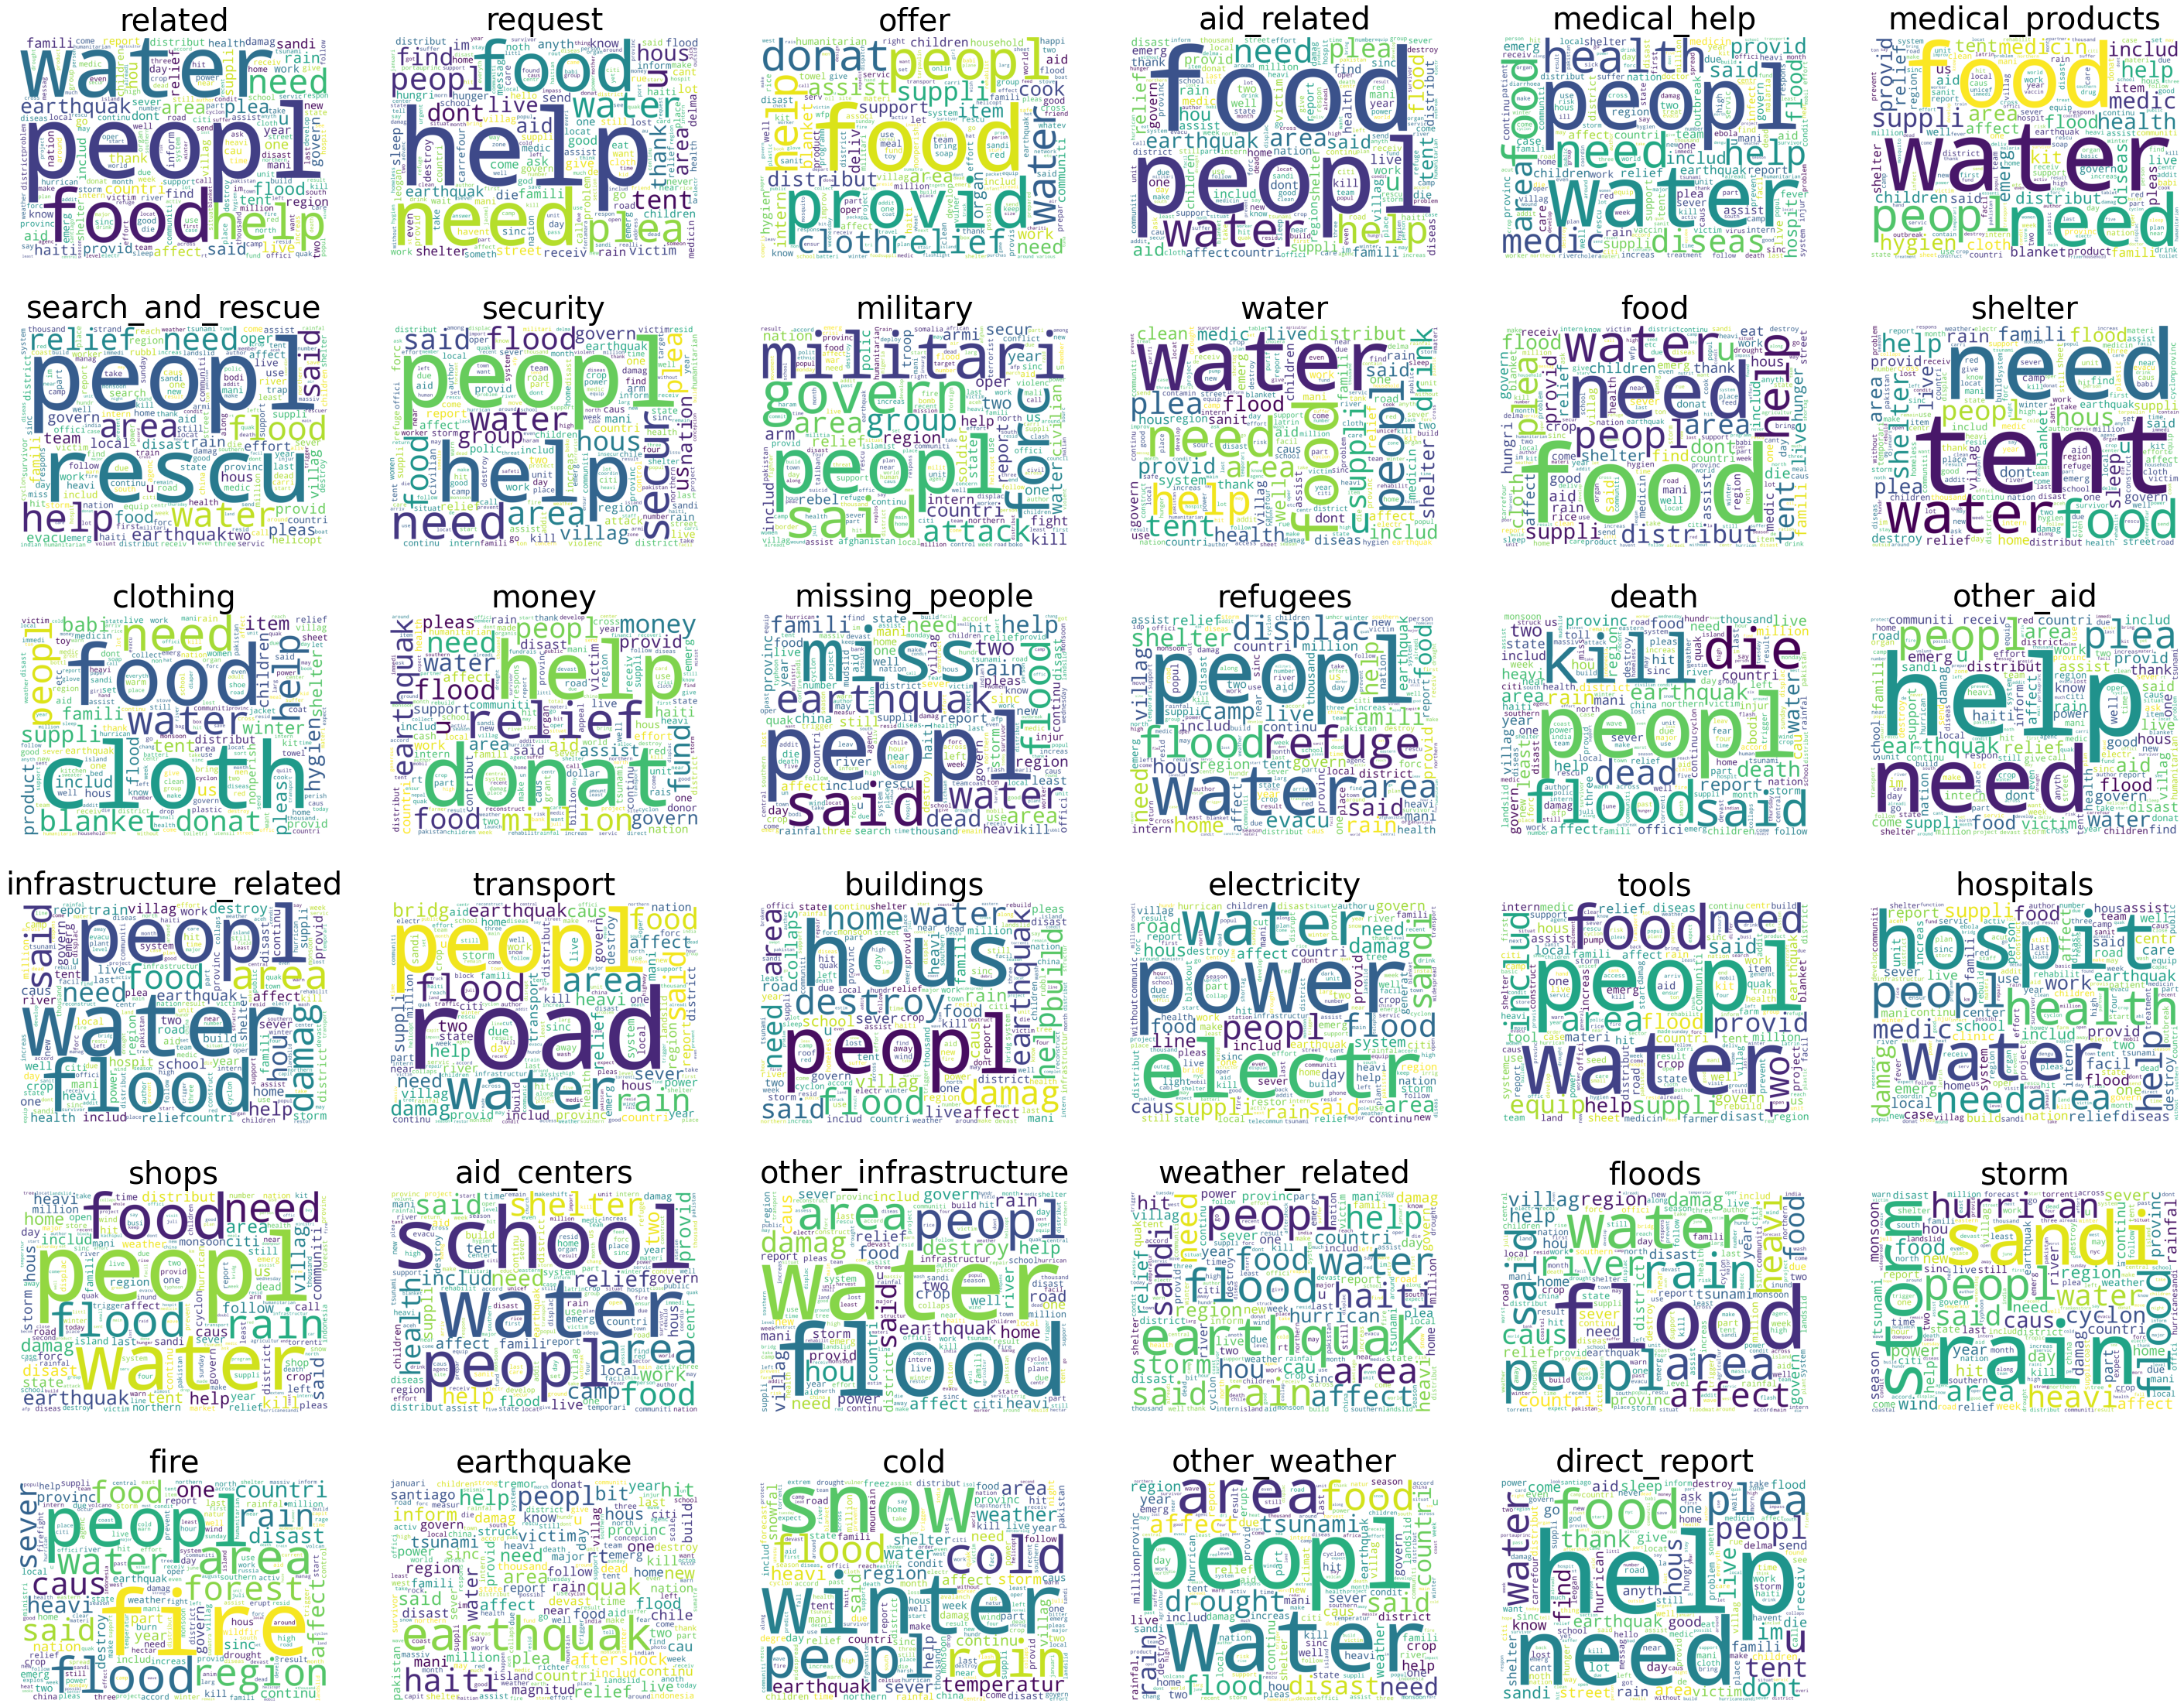

In [92]:
from wordcloud import WordCloud,STOPWORDS


plt.figure(figsize=(50,40))
count = 1
for col in categories:
    subset = df[df[col]==1]
    text = subset.message.values
    cloud_toxic = WordCloud(
                              stopwords=STOPWORDS,
                              background_color='white',
                              collocations=False,
                              width=2500,
                              height=1800
                             ).generate(" ".join(text))

    plt.subplot(6, 6, count)
    plt.axis('off')
    plt.title(col,fontsize=40)
    plt.imshow(cloud_toxic)
    count += 1

plt.show()



In [66]:
# use the english model that you have
nlp = spacy.load('en_core_web_sm')


In [67]:
# Create a text file to add stop words
with open('/disaster_response/stopwords.txt', 'r') as f:
    str_f = f.read()
    stopwords_file = set(str_f.split('\n'))
nlp.Defaults.stop_words |= stopwords_file

In [68]:
# Add more stop words
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
nlp.Defaults.stop_words |= stopWords

In [69]:
def term_freq(df):
    corpus = (st.CorpusFromPandas(df,
                                           category_col='help_needed', 
                                           text_col='message',
                                           nlp=nlp)
              .build()
              .remove_terms(nlp.Defaults.stop_words, ignore_absences=True)
              # ignore_absences: if the term does not appear, don't raise an error, just move on.
              )
    
    df = corpus.get_term_freq_df()
    df['Yes_Score'] = corpus.get_scaled_f_scores('Yes')
    df['No_Score'] = corpus.get_scaled_f_scores('No')

    df['Yes_Score'] = round(df['Yes_Score'], 2)
    df['No_Score'] = round(df['No_Score'], 2)
    
    df_yes = df.sort_values(by='Yes freq', 
                             ascending = False).reset_index()
    df_no = df.sort_values(by='No freq', 
                            ascending=False).reset_index()
    
    return df_yes, df_no, df, corpus

In [70]:
df_yes, df_no, df_new, corpus = term_freq(df)

In [71]:
# Sorted by help needed Frequency
df_yes.head(15)

term  Yes freq  No freq  Yes_Score  No_Score
0       people      2657      273       0.96      0.04
1        water      2582      244       0.96      0.04
2         food      2512      192       0.97      0.03
3         help      2332      240       0.96      0.04
4   earthquake      1704       40       0.99      0.01
5        haiti       898      109       0.95      0.05
6        areas       891       93       0.96      0.04
7        sandy       762       72       0.96      0.04
8       relief       755       38       0.98      0.02
9   government       732      173       0.90      0.10
10         aid       728       33       0.98      0.02
11        find       663      252       0.14      0.86
12      health       638       90       0.94      0.06
13        area       604       67       0.95      0.05
14     country       598      196       0.16      0.84

In [72]:
# Sorted by No help needed Frequency
df_no.head(15)

term  Yes freq  No freq  Yes_Score  No_Score
0      message       265      314       0.05      0.95
1         good       425      286       0.09      0.91
2       people      2657      273       0.96      0.04
3         find       663      252       0.14      0.86
4          job       109      250       0.02      0.98
5        water      2582      244       0.96      0.04
6        notes       103      243       0.02      0.98
7         help      2332      240       0.96      0.04
8         work       363      197       0.11      0.89
9      country       598      196       0.16      0.84
10        food      2512      192       0.97      0.03
11  government       732      173       0.90      0.10
12         i m       443      170       0.14      0.86
13    santiago       269      152       0.10      0.90
14      school       299      151       0.11      0.89

In [75]:
df

id                                            message  \
0          2    weather update cold front cuba could pass haiti   
1          7                                          hurricane   
2          8                               looking someone name   
3          9  un reports leogane 8090 destroyed hospital st ...   
4         12    says west side haiti rest country today tonight   
...      ...                                                ...   
26211  30261  training demonstrated enhance micronutrient pr...   
26212  30262  suitable candidate selected ocha jakarta curre...   
26213  30263  proshika operating coxs bazar municipality 5 u...   
26214  30264  2000 women protesting conduct elections tearga...   
26215  30265  radical shift thinking came result meeting rec...   

                                                original   genre  related  \
0      Un front froid se retrouve sur Cuba ce matin. ...  direct        1   
1                     Cyclone nan fini osinon li pa fini  direct        1   
2      Patnm, di Maryani relem pou li banm nouvel li ...  direct        1   
3      UN reports Leogane 80-90 destroyed. Only Hospi...  direct        1   
4      facade ouest d Haiti et le reste du pays aujou...  direct        1   
...                                                  ...     ...      ...   
26211                                               None    news        0   
26212                                               None    news        0   
26213                                               None    news        1   
26214                                               None    news        1   
26215                                               None    news        1   

       request  offer  aid_related  medical_help  medical_products  ...  \
0            0      0            0             0                 0  ...   
1            0      0            1             0                 0  ...   
2            0      0            0             0                 0  ...   
3            1      0            1             0                 1  ...   
4            0      0            0             0                 0  ...   
...        ...    ...          ...           ...               ...  ...   
26211        0      0            0             0                 0  ...   
26212        0      0            0             0                 0  ...   
26213        0      0            0             0                 0  ...   
26214        0      0            1             0                 0  ...   
26215        0      0            0             0                 0  ...   

       weather_related  floods  storm  fire  earthquake  cold  other_weather  \
0                    0       0      0     0           0     0              0   
1                    1       0      1     0           0     0              0   
2                    0       0      0     0           0     0              0   
3                    0       0      0     0           0     0              0   
4                    0       0      0     0           0     0              0   
...                ...     ...    ...   ...         ...   ...            ...   
26211                0       0      0     0           0     0              0   
26212                0       0      0     0           0     0              0   
26213                0       0      0     0           0     0              0   
26214                0       0      0     0           0     0              0   
26215                0       0      0     0           0     0              0   

       direct_report  help_needed  match  
0                  0          Yes   True  
1                  0          Yes   True  
2                  0          Yes   True  
3                  0          Yes   True  
4                  0          Yes   True  
...              ...          ...    ...  
26211              0           No   True  
26212              0           No   True  
26213              0          Y

In [76]:
# Label each excerpt with the name of category using the metadata parameter
corpus_dataframe = df
html = st.produce_scattertext_explorer(corpus,
                                                category='No',
                                                category_name='No',
                                                not_category_name='Yes',
                                                width_in_pixels=1000)

In [77]:
html_file_name = "Disaster-Scattertext.html"
open(html_file_name, 'wb').write(html.encode('utf-8'))

5119608